In [3]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

Deber : Slin Castro

# Indice
1. [Código en clase](#1-codigo-en-clase)
2. [Creacion en codigo de la expresion matematica ](#2-creacion-en-codigo-de-la-funcion-)
3. [Obteniendo gradientes con la funcion L.backward() ](#3-obteniendo-gradientes-con-la-funcion-lbackward)
4. [Obteniendo gradientes 1 a 1 manualmente](#4-calculo-manual-de-los-gradientes-1-por-1)
5. [Comparacion de valores manual vs L.Backward()](#5-comparacion-de-valores-obtenidos-por-la-funcion-lbackward)
6. [Conclusiones](#6-conclusiones)


# 1. Codigo en Clase

[Inicio](#indice)

In [77]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(label={self.label} - data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()




In [41]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [43]:
from graphviz import Digraph

def draw_dot_vertical(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR', 'nodesep': '0.5', 'ranksep': '0.7'}) 

    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        node_label = f"{{ {n.label} | data: {n.data:.4f} | grad: {n.grad:.4f} }}"
        
        # Use different colors for operation nodes and value nodes
        if n._op:
            dot.node(name=uid, label=node_label, shape='record', style='filled', fillcolor='lightblue', fontcolor='black')
            dot.node(name=uid + n._op, label=n._op, shape='ellipse', style='filled', fillcolor='lightgray', fontcolor='black')
            dot.edge(uid + n._op, uid)  # Connect operation to its output node
        else:
            dot.node(name=uid, label=node_label, shape='record', style='filled', fillcolor='lightgreen', fontcolor='black')

    for n1, n2 in edges:
        # Connect input nodes to operation nodes
        dot.edge(str(id(n1)), str(id(n2)) + n2._op, color='black')

    return dot


In [6]:
def f(x):
  return 3*x**2 - 4*x + 5

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]


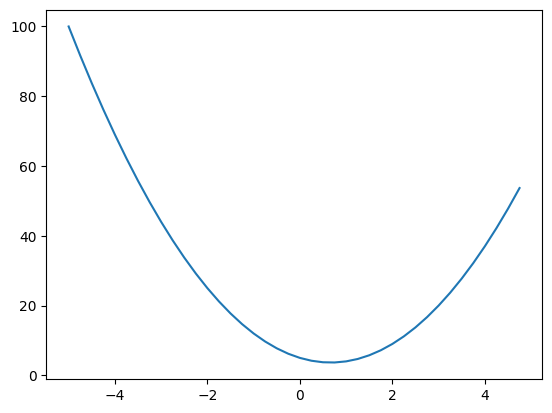

In [7]:
xs = np.arange(-5, 5, 0.25)
print(xs)
ys = f(xs)
plt.plot(xs, ys)

In [8]:
f(xs)

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

In [9]:
expr_a = 0.000001
x = 2/3   # 2/3
print(x)
(f(x + expr_a) - f(x))/expr_a

0.6666666666666666


2.999378523327323e-06

In [10]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c #funcion multivariable e.g., f(a,b,c)
print(d)

4.0


In [11]:
a=2
b=3
c=1
d=1
e=4
f=2
g=5

L = ((a*b+c)**2+d+e*f)*g

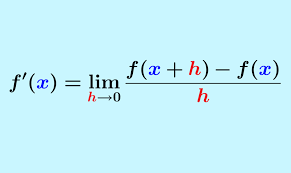

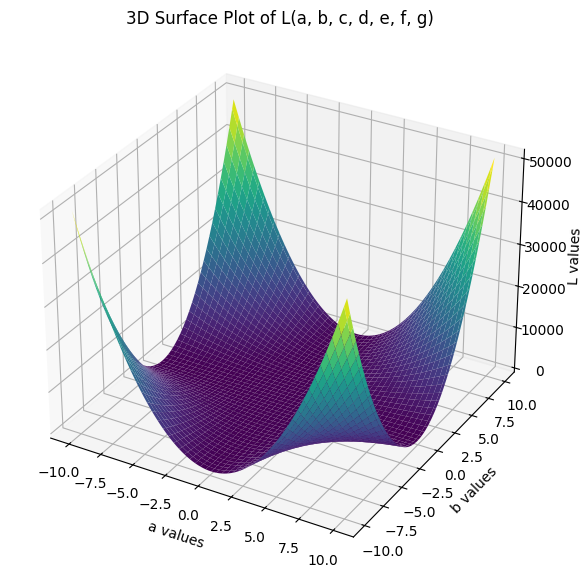

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def L(a, b, c, d, e, f, g):
    return ((a * b + c) ** 2 + d + e * f) * g


a_values = np.linspace(-10, 10, 100)
b_values = np.linspace(-10, 10, 100)

c, d, e, f, g = 1, 2, 3, 4, 5

A, B = np.meshgrid(a_values, b_values)
L_values = L(A, B, c, d, e, f, g)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(A, B, L_values, cmap='viridis', edgecolor='none')

ax.set_xlabel('a values')
ax.set_ylabel('b values')
ax.set_zlabel('L values')
ax.set_title('3D Surface Plot of L(a, b, c, d, e, f, g)')

plt.show()

In [13]:
expr_a = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += expr_a
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/expr_a)


d1 4.0
d2 4.0002
slope 2.0000000000042206


In [22]:
a = Value(2.0, label='a')
print(a)
b = Value(-3.0, label='b')
print(b)
c = Value(10.0, label='c')
print(c)
e = a*b; e.label = 'e'
print(e)
d = e + c; d.label = 'd'
print(d)
f = Value(-2.0, label='f')
print(f)
L = d * f; L.label = 'L'
print(L)

Value(data=2.0)
Value(data=-3.0)
Value(data=10.0)
Value(data=-6.0)
Value(data=4.0)
Value(data=-2.0)
Value(data=-8.0)


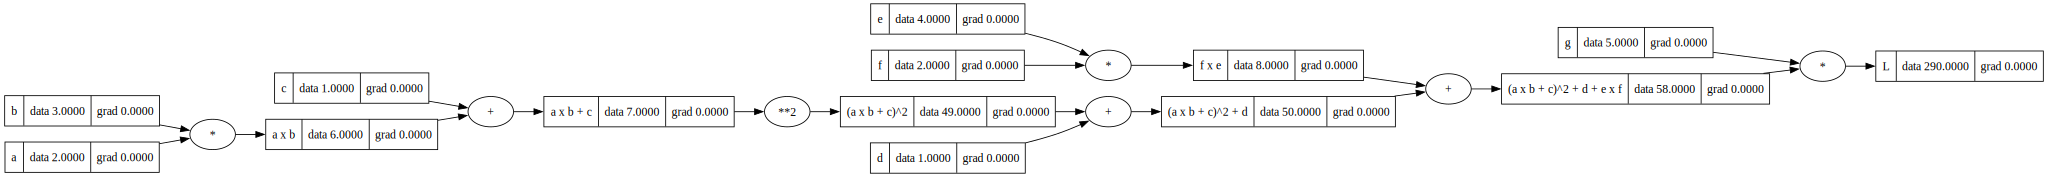

In [42]:
draw_dot(L)

# 2. Creacion en codigo de la expresion matematica :

$$
L = \left( (a \times b + c)^2 + d + e \times f \right) \times g
$$


[Indice](#indice)

Value(label=a - data=2.0)
Value(label=b - data=3.0)
Value(label=c - data=1.0)
Value(label=d - data=1.0)
Value(label=e - data=4.0)
Value(label=f - data=2.0)
Value(label=g - data=5.0)
Value(label=a x b - data=6.0)
Value(label=(a x b + c)^2 - data=49.0)
Value(label=L - data=290.0)


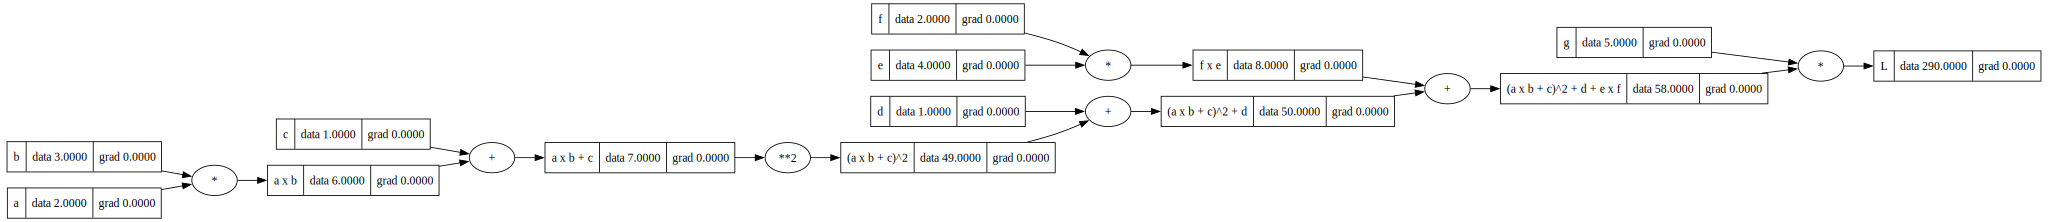

In [107]:

a = Value(2.0, label='a')
print(a)

b = Value(3.0, label='b')
print(b)

c = Value(1.0, label='c')
print(c)

d = Value(1.0, label='d')
print(d)

e = Value(4.0, label='e')
print(e)

f = Value(2.0, label='f')
print(f)

fe = f*e
fe.label = 'f x e'

g = Value(5.0, label='g')
print(g)


axb = a*b 
axb.label = 'a x b'
print(axb)

axb_c = axb + c
axb_c.label = 'a x b + c'

axb_c2 = axb_c**2
axb_c2.label = '(a x b + c)^2'
print(axb_c2)

expr_a = axb_c2 + d
expr_a.label = '(a x b + c)^2 + d'

expr_b= expr_a + fe
expr_b.label = '(a x b + c)^2 + d + e x f'

final = expr_b * g
final.label = 'L'

L = final

print(L)

draw_dot(L)

# 3. Obteniendo Gradientes con la Funcion L.backward()

[Indice](#indice)

a.grad = 210.0
b.grad = 140.0
c.grad = 70.0
d.grad = 5.0
e.grad = 10.0
f.grad = 20.0
g.grad = 58.0


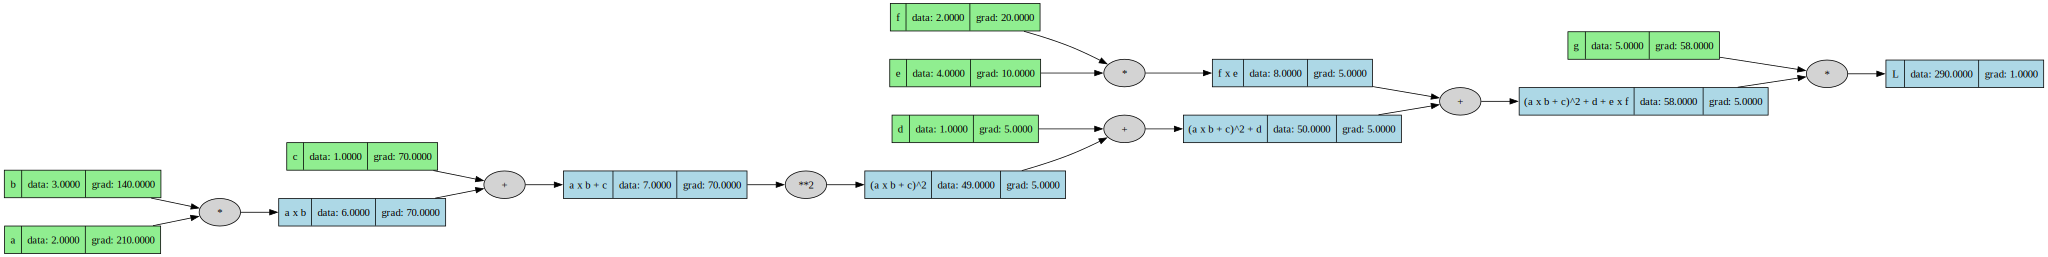

In [108]:
L = final
L.backward()

L.grad=1

comparation = {}
comparation["a"] = a.grad
comparation["b"] = b.grad
comparation["c"] = c.grad
comparation["d"] = d.grad
comparation["e"] = e.grad
comparation["f"] = f.grad
comparation["g"] = g.grad

print(f"a.grad = {a.grad}")
print(f"b.grad = {b.grad}")
print(f"c.grad = {c.grad}")
print(f"d.grad = {d.grad}")
print(f"e.grad = {e.grad}")
print(f"f.grad = {f.grad}")
print(f"g.grad = {g.grad}")

draw_dot_vertical(L)

# 4. Calculo manual de los gradientes 1 por 1

[Indice](#indice)

In [101]:
L.grad = 1.0

expr_b.grad = g.data * L.grad  # dL/dexpr_b = g
g.grad = expr_b.data * L.grad  # dL/dg = expr_b

expr_a.grad = expr_b.grad  # dL/dexpr_a = dL/dexpr_b
fe.grad = expr_b.grad  # dL/dfe = dL/dexpr_b

axb_c2.grad = expr_a.grad  # dL/d(axb_c2) = dL/d(expr_a)
d.grad = expr_a.grad  # dL/d(d) = dL/d(expr_a)

axb_c.grad = axb_c2.grad * (2 * axb_c.data)  # dL/d(axb_c)

axb.grad = axb_c.grad  # dL/d(axb)
c.grad = axb_c.grad  # dL/d(c)

a.grad = axb.grad * b.data  # dL/da
b.grad = axb.grad * a.data  # dL/db

f.grad = fe.grad * e.data  # dL/df
e.grad = fe.grad * f.data  # dL/de

to_compare = {}
to_compare["a"] = a.grad
to_compare["b"] = b.grad
to_compare["c"] = c.grad
to_compare["d"] = d.grad
to_compare["e"] = e.grad
to_compare["f"] = f.grad
to_compare["g"] = g.grad


print(f"a.grad = {a.grad}")
print(f"b.grad = {b.grad}")
print(f"c.grad = {c.grad}")
print(f"d.grad = {d.grad}")
print(f"e.grad = {e.grad}")
print(f"f.grad = {f.grad}")
print(f"g.grad = {g.grad}")





a.grad = 210.0
b.grad = 140.0
c.grad = 70.0
d.grad = 5.0
e.grad = 10.0
f.grad = 20.0
g.grad = 58.0


## 5. Comparacion de Valores Obtenidos por la funcion L.backward()

[Indice](#indice)

In [109]:
for key in comparation.keys():
    print(f"{key} Los gradientes son iguales ?: {comparation[key] == to_compare[key]} gradiente calculado: {to_compare[key]} gradiente calculado con autograd: {comparation[key]}")

a Los gradientes son iguales ?: True gradiente calculado: 210.0 gradiente calculado con autograd: 210.0
b Los gradientes son iguales ?: True gradiente calculado: 140.0 gradiente calculado con autograd: 140.0
c Los gradientes son iguales ?: True gradiente calculado: 70.0 gradiente calculado con autograd: 70.0
d Los gradientes son iguales ?: True gradiente calculado: 5.0 gradiente calculado con autograd: 5.0
e Los gradientes son iguales ?: True gradiente calculado: 10.0 gradiente calculado con autograd: 10.0
f Los gradientes son iguales ?: True gradiente calculado: 20.0 gradiente calculado con autograd: 20.0
g Los gradientes son iguales ?: True gradiente calculado: 58.0 gradiente calculado con autograd: 58.0


# 6. Conclusiones

[Indice](#indice)

- El uso de backward() en frameworks como PyTorch permite automatizar el cálculo de gradientes, eliminando la necesidad de derivar cada expresión manualmente. Esto es particularmente útil en modelos de aprendizaje profundo, donde las funciones de costo y sus derivadas pueden volverse extremadamente complejas. 

- El cálculo manual de gradientes ofrece una comprensión más profunda de cómo funciona la diferenciación y cómo se propagan los errores a lo largo de un grafo computacional. Aplicando reglas como la derivada del producto, la regla de la cadena y la derivada de potencias, podemos derivar cualquier expresión matemática paso a paso. 

- Ambos enfoques tienen su lugar. Si el objetivo es aprender autodiferenciación desde cero, calcular gradientes manualmente es una excelente forma de desarrollar intuición matemática. Sin embargo, para aplicaciones prácticas en Machine Learning, backward() es la opción más eficiente y confiable.

- Si la funcion Backward se sigue ejecutando , los valores se siguen incrementando.
